# Contents

*  Problem Statement
*  Gather Data
*  EDA (Inspect/Viz/Clean)
*  Models
*  Analysis


## Problem Statement

An individual's profession and career can be fundamental to not only their economic prosperity, but also their mental and emotional well-being. There are a lot of considerations when it comes to finding a job, but among them are the components that make up the day-to-day activities of work. These can be described as several different features:
*  Knowledge
*  Skills
*  Abilities
*  Work activities

But what happens when someone wants to change their role, but also wants to properly transition their skillset to a new role? This can happen for a variety of reasons. Sometimes, this can be a simple change of desire, in which someone might use a career coach, mentor, etc.

However, there are other reasons someone may switch job titles, which will be discussed below. When these reasons are out of someone's hands, they may want to find jobs most similar to theirs. How can this be done algorithmically?

## Gather data
Data was collected from the O*NET Online data system, which is sponsored by the U.S. Department of Labor. All the information can be accessed from here. Specifically for this project, data was accessed from the 26.3 database, downloaded as a zipped file of Excel documents, and uploaded to Google Drive for access below.

https://www.onetcenter.org/database.html#individual-files

In [14]:
# Import necesssary packages.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Mount to Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set a path and read in Excel sheets for our necessary 
path = 'drive/My Drive/graduate_school/msds_cu_boulder/block_7/machine_learning_2/final_project/db_26_2_excel/'

skills_df = pd.read_excel(path+'Skills.xlsx')
knowledge_df = pd.read_excel(path+'Knowledge.xlsx')
abilities_df = pd.read_excel(path+'Abilities.xlsx')
work_activity_df = pd.read_excel(path+'Work Activities.xlsx')

## EDA (Inspect/Viz/Clean)

In [7]:
# First quick inspection.
print(skills_df.shape)
print(skills_df.head())
print(len(pd.unique(skills_df['O*NET-SOC Code'])))

(61110, 15)
  O*NET-SOC Code             Title Element ID           Element Name Scale ID  \
0     11-1011.00  Chief Executives    2.A.1.a  Reading Comprehension       IM   
1     11-1011.00  Chief Executives    2.A.1.a  Reading Comprehension       LV   
2     11-1011.00  Chief Executives    2.A.1.b       Active Listening       IM   
3     11-1011.00  Chief Executives    2.A.1.b       Active Listening       LV   
4     11-1011.00  Chief Executives    2.A.1.c                Writing       IM   

   Scale Name  Data Value    N  Standard Error  Lower CI Bound  \
0  Importance        4.12  8.0            0.13            3.88   
1       Level        4.75  8.0            0.16            4.43   
2  Importance        4.12  8.0            0.13            3.88   
3       Level        4.88  8.0            0.23            4.43   
4  Importance        4.00  8.0            0.00            4.00   

   Upper CI Bound Recommend Suppress Not Relevant     Date Domain Source  
0            4.37            

Upon first inspection, it appears that the dataframe for "skills" is 61,110 rows by 15 columns. The columns value makes sense just by looking, although we know from documentation that there should be 873 data-level occupations. What we see is there are duplicate rows for various occupations due to the following factors:
*  "Elements" (here, Skills) are in repeated rows, and
*  There is another qualifier for "Level" or "Importance".

Here I'm using domain knowledge to know that for this analysis, we are interested in Importance. With these two things in mind, our preprocessing will involve:
*  Filtering dataframdes to "Importance" and
*  Pivoting dataframes to have occupations in rows and "elements" in columns", which can then be merged.

In [8]:
# Filter down to element importance levels.
skills_df = skills_df[skills_df['Scale ID'] == 'IM']
knowledge_df = knowledge_df[knowledge_df['Scale ID'] == 'IM']
abilities_df = abilities_df[abilities_df['Scale ID'] == 'IM']
work_activity_df = work_activity_df[work_activity_df['Scale ID'] == 'IM']

titles_df = skills_df[['O*NET-SOC Code', 'Title']].copy()

In [9]:
# Drop unneccesary columns and then pivot each dataframe.
skills_df = skills_df[['O*NET-SOC Code', 'Element Name', 'Data Value']].copy()
skills_df = skills_df.pivot_table(index = 'O*NET-SOC Code', columns='Element Name')

knowledge_df = knowledge_df[['O*NET-SOC Code', 'Element Name', 'Data Value']].copy()
knowledge_df = knowledge_df.pivot_table(index = 'O*NET-SOC Code', columns='Element Name')

abilities_df = abilities_df[['O*NET-SOC Code', 'Element Name', 'Data Value']].copy()
abilities_df = abilities_df.pivot_table(index = 'O*NET-SOC Code', columns='Element Name')

work_activity_df = work_activity_df[['O*NET-SOC Code', 'Element Name', 'Data Value']].copy()
work_activity_df = work_activity_df.pivot_table(index = 'O*NET-SOC Code', columns='Element Name')


In [10]:
# Now let's take a look at each of these to make sure our shapes make sense.
print(skills_df.shape, knowledge_df.shape, abilities_df.shape, work_activity_df.shape)

code_index_dict = {}

for i in range(0, len(skills_df.index)):
  code_index_dict[i] = [skills_df.index[i], list(titles_df.loc[titles_df['O*NET-SOC Code'] == skills_df.index[i], 'Title'].sample(n=1))[0]]

(873, 35) (873, 33) (873, 52) (873, 41)


Now that we have our paired-down and properly structured dataframe, we're going to build our large dataframe to actually work with during our modeling phase.

In [11]:
large_df = pd.concat([skills_df, knowledge_df, abilities_df, work_activity_df], axis=1)
leaves = large_df.index.values

In [21]:
print(large_df.shape)
print(large_df.head)

(873, 161)
<bound method NDFrame.head of                     Data Value                                           \
Element Name   Active Learning Active Listening Complex Problem Solving   
O*NET-SOC Code                                                            
11-1011.00                4.00             4.12                    4.38   
11-1011.03                3.75             4.00                    4.00   
11-1021.00                3.50             4.00                    3.50   
11-2011.00                3.25             4.12                    3.50   
11-2021.00                3.88             3.88                    3.62   
...                        ...              ...                     ...   
53-7071.00                2.88             3.12                    3.00   
53-7072.00                2.88             3.12                    2.88   
53-7073.00                2.38             2.88                    3.00   
53-7081.00                2.50             2.88            

We know to do clustering we're going to convert this to a numpy array/matrix, so let's go ahead and do that and do a little more exploration. We can see after the matrix that we have 161 features we will be working with and 873 occupations.

In [22]:
large_matrix = np.array(large_df)
print(large_matrix.shape)
print(large_matrix)

(873, 161)
[[4.   4.12 4.38 ... 3.   4.06 4.2 ]
 [3.75 4.   4.   ... 3.63 4.3  4.15]
 [3.5  4.   3.5  ... 3.94 3.63 4.15]
 ...
 [2.38 2.88 3.   ... 3.48 3.31 3.53]
 [2.5  2.88 2.75 ... 2.66 2.92 1.62]
 [2.75 3.   3.   ... 3.45 3.84 2.82]]


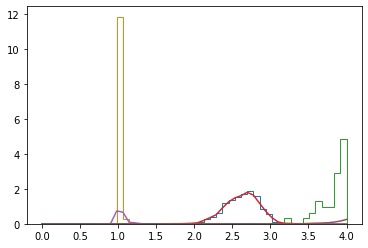

In [20]:
avgs = []
mins = []
maxs = []

for i in range(0, len(large_matrix)):
  avgs.append(np.mean(large_matrix[i]))
  mins.append(min(large_matrix[i]))
  maxs.append(max(large_matrix[i]))

avg_density = stats.gaussian_kde(avgs)
min_density = stats.gaussian_kde(mins)
max_density = stats.gaussian_kde(maxs)
n, x, _ = plt.hist(avgs, bins=np.linspace(0, 4, 50), 
                   histtype=u'step', density=True)  
n, x1, _ = plt.hist(mins, bins=np.linspace(0, 4, 50), 
                   histtype=u'step', density=True)  
n, x2, _ = plt.hist(maxs, bins=np.linspace(0, 4, 50), 
                   histtype=u'step', density=True)  
plt.plot(x, avg_density(x))
plt.plot(x1, min_density(x1))
plt.plot(x2, max_density(x2))
plt.show()

So by the look of it, all of our characteristics/elements are between 0 and 4, with an average somewhere between 2.5 and 3.0, although this is likely to be unique to each element across all occupations. Because these values appear to already be normalized, no other data transformations will be necessary. Although some restructuring was necessary for this analysis, cleaning was on the relatively light side.

## Models

In [23]:
# Import our packages specific to modeling.
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

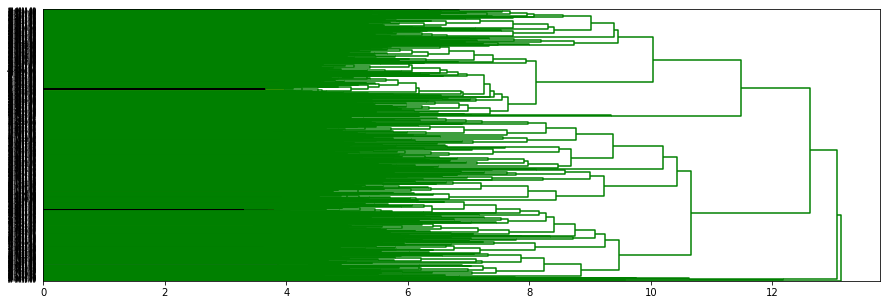

In [27]:
# Let's first build our distance matrix, calculating distance between each occupation based on all featurs.
dists = pdist(large_matrix, metric = "euclidean")

temp = linkage(dists, 'average')

plt.figure(figsize=(15, 5))

dn = dendrogram(temp, labels = leaves, above_threshold_color="green", 
                color_threshold=4, orientation='right')#, truncate_mode='lastp', p=21)  

In [28]:
# And here we're going to get our distance matrix into a useable format.
dist_cond_matrix = squareform(dists)
print(dist_cond_matrix.shape)

(873, 873)


In [31]:
#current_job = '15-2051.01'
current_job = '29-1229.04'
current_job_code = list(s for s in code_index_dict if code_index_dict[s][0]==current_job)[0]
current_job_title = code_index_dict[current_job_code][1]


close_array = dist_cond_matrix[current_job_code]
lowest_indx = np.argsort(close_array)[:11]
highest_indx = np.argsort(close_array)[-5:]

print("Current job title: ", current_job_title)
print("The 10 closest jobs in terms of knowledge, skills, and ability importance are:")

for j in range(0, len(lowest_indx)):
  if code_index_dict[lowest_indx[j]][0] == current_job:
    pass
  else:
    print(code_index_dict[lowest_indx[j]][0], code_index_dict[lowest_indx[j]][1])
print("")
print("The 5 most different jobs from your current are:")

for k in range(0, len(highest_indx)):
  print(code_index_dict[highest_indx[k]][0], code_index_dict[highest_indx[k]][1])

Current job title:  Physical Medicine and Rehabilitation Physicians
The 10 closest jobs in terms of knowledge, skills, and ability importance are:
29-1141.04 Clinical Nurse Specialists
29-1171.00 Nurse Practitioners
29-1161.00 Nurse Midwives
29-1218.00 Obstetricians and Gynecologists
25-1072.00 Nursing Instructors and Teachers, Postsecondary
29-1071.00 Physician Assistants
29-1216.00 General Internal Medicine Physicians
29-1229.02 Hospitalists
29-1224.00 Radiologists
29-1041.00 Optometrists

The 5 most different jobs from your current are:
47-3014.00 Helpers--Painters, Paperhangers, Plasterers, and Stucco Masons
53-7061.00 Cleaners of Vehicles and Equipment
41-9041.00 Telemarketers
45-4021.00 Fallers
41-9012.00 Models


In [30]:
clusters = list(fcluster(temp, 24.2, criterion='distance'))
groups = {}
for i in range (0, len(leaves)):
  if clusters[i] in groups:
    groups[clusters[i]].append(leaves[i])
  else:
    groups[clusters[i]] = [leaves[i]]
groups = dict(sorted(groups.items()))
rtrn_groups_df = pd.DataFrame.from_dict(groups, orient='index').transpose()
new_col_names = []
for col in rtrn_groups_df.columns:
    new_col_names.append(str(col))
rtrn_groups_df.columns = new_col_names

display(rtrn_groups_df)

,1
0,11-1011.00
1,11-1011.03
2,11-1021.00
3,11-2011.00
4,11-2021.00
...,...
868,53-7071.00
869,53-7072.00
870,53-7073.00
871,53-7081.00


## Analysis

What we have are the "guts" behind what could be a very helpful tool. Potential next steps beyond what is presented here include the following:
*  Continued hyperparameter tuning based on iterative feedback from users of an app.
*  Closeness calculations based off of particular element types rather than all elements (say, Knowledge and Skills, but not Work Activities).
*  Application feature optimization, such as level-setting for individual features.

## Conclusion
After this work, we now have a sense of how occupation groups are organized and how we can manually cluster them based on knowledge, skills, abilities, and work activities, rather than simply based on occpuation type and industry classification.

Additionally, the clustering work done here can be the basis to potential applications for job seekers, and specifically those re-entering the workforce after prolonged absences based on old and acquired skills which can easily transfer over to a new setting.